# 5. Übung Nichtlineare Regelungstechnik 1, Aufgabe 3

## Robuste Auslegung eines Reglers nach dem Backstepping-Verfahren

System:

\begin{align*}
\dot x_1 &= x_2 + \sin(x_1)\\
\dot x_2 &= a x_1^2 + u
\end{align*}

mit $|a| < 2$ und $|x_1| < \sigma$

---

Die aktuelle Fassung dieses Notebooks findet sich in folgendem Repositorium:

https://gitlab.hrz.tu-chemnitz.de/rst/public/teaching/nl1-nbviewer-content

Sie können zur Entwicklung/ Verbesserung über Merge Requests beitragen!

---

<p style="font-family:Courier New; font-size:10pt">
Copyright (c) 2019-2023 Jan Winkler, TU Dresden, Germany
</p>

<p style="font-family:Courier New; font-size:10pt">
This program is free software: you can redistribute it and/or modify<br>
it under the terms of the GNU General Public License as published by<br>
the Free Software Foundation, either version 3 of the License, or<br>
(at your option) any later version.
</p>
    
<p style="font-family:Courier New; font-size:10pt">
This program is distributed in the hope that it will be useful,<br>
but WITHOUT ANY WARRANTY; without even the implied warranty of<br>
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br>
GNU General Public License for more details: <br>
<a href=https://www.gnu.org/licenses/gpl-3.0.txt>https://www.gnu.org/licenses/gpl-3.0.txt</a>.
</p>

---

## Vorbereitungen für die Simulation

### Benötigte Pakete

In [1]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
# %matplotlib widget  # <- Aktivieren für interaktive Plots

### Definition des Stop-Events
In dieser Simulationsstudie werden auch Konfigurationen untersucht, bei der die zu stabilisierende Ruhelage tatsächlich instabil ist. Da die Simulation dann zu sehr großen Werten des Zustandes führt und man in der grafischen Darstellung nichts mehr von den eigentlich interessanten Verläufen sieht, wird dem Dgl.-Löser diese Funktion übergeben. Sie sorgt dafür, dass die Simulation abbricht, sobald die Norm des Zustandes größer ist als 3, der Zustand also außerhalb eines Kreises mit dem Radius 3 um den Ursprung befindet..

<div class="alert alert-block alert-info">
    <b>Tip:</b> Schauen Sie in der <a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html>Dokumentation des Dgl-Lösers</a> nach, um sich genauer zu informieren. Matlab-Äquivalent: <a href=https://de.mathworks.com/help/matlab/math/ode-event-location.html>ode event</a>
</div>

In [2]:
def stop_event(t, x):
    return np.linalg.norm(x) - 3


stop_event.terminal = True  # <-- Python: Einer Funktion können Attribute zugeordnet werden
stop_event.direction = 1

### Definition der rechten Seite der Systemdifferenzialgleichung

Siehe Gleichung (8) in der Übungslösung. Mit Regelgesetz, welches von $|a| < 2$ ausgeht.

In [3]:
def dgl_sys(x, a, k_1, k_2):
    x1, x2 = x

    # Hilfsgrößen
    z2 = x2 + (k_1 + 1) * x1
    psi = x1 - (k_1 + 1)**2 * x1 + (k_1 + 1) * np.sin(x1) + (k_1 + 1) * z2

    # Regler
    u = -psi - k_2 * z2

    # System
    x1_dot = x2 + np.sin(x1)
    x2_dot = a * x1**2 + u

    return [x1_dot, x2_dot]

### Funktion zu Berechnung von $k_2$. 
Es wurde hergeleitet:

$$
k_2 > \frac{\sigma^2}{k_1}
$$

Also wird folgende Funktion mit Faktor 1.1 definiert, um die "Größer-Bedingung" zu erfüllen.

In [4]:
def calc_k2(k_1, sigma):
    return 1.1 * sigma**2 / k_1

### Simulationsparameter

In [5]:
# Anfangszustand
x_0 = [1, 1]

# Simulationszeit in s
t_sim = 15

# Auswertezeitpunkte Lösung
t = np.linspace(0, t_sim, 1000)

## Erste Simulationstudie: System weist unterschiedliche Werte für $a$ auf

**Auslegungsparameter**:
$|a| < 2$, $k_1$ = 2.0, $\sigma = 2.0$

Es wird geprüft, wie sich der geschlossene Regelkreise für unterschiedliche Werte von $a$ im Regelstreckenmodell verhält. In allen Fällen wird innherlab des Reglers $a < 2$ angenommen.

**Beobachtung**:
Liegt das tatsächliche $a$ außerhalb der für den Entwurf zugrundegelegten Spezifikation, so kann die Stabilität nicht mehr *garantiert* werden. Tatsächlich kann das $a$ deutlich größere Werte annehmen, als die Spezifikation $|a| < 2$ vermuten lässt (nämlich bis 4.5). Grund hierfür ist, dass der Entwurf auf Abschätzungen basiert.

<div class="alert alert-block alert-info">
    <b>Bemerkung:</b> <code>lambda t, y: dgl_sys(x, a, k_1, k_2)</code> sorgt dafür, dass der Funktionsaufruf <code>dgl_sys(x, a, k_1, k_2</code> für den Löser so aussieht wie <code>dgl_sys(t, y)</code>, aber dennoch die Parameter <code>a, k_1, k_2</code> übergeben werden.
</div>

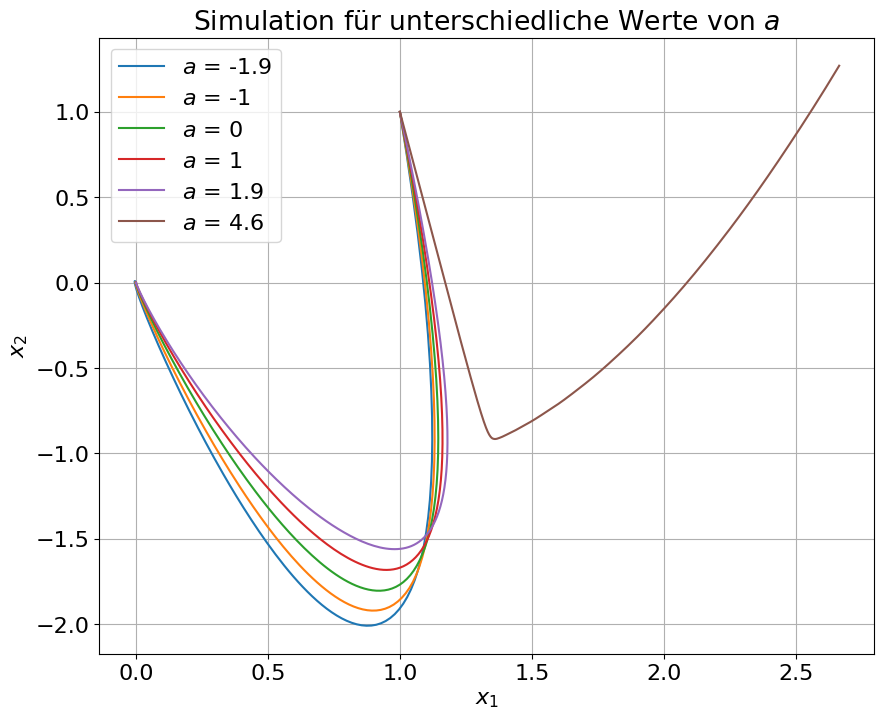

In [6]:
a_values = [-1.9, -1, 0, 1, 1.9, 4.6]
sigma = 2.0
k_1 = 2.0
k_2 = calc_k2(k_1, sigma)
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10,8))
for a in a_values:
    sol = sci.solve_ivp(lambda t, x: dgl_sys(x, a, k_1, k_2), [0, t_sim], x_0, t_eval=t, events=[stop_event])
    plt.plot(sol.y[0, :], sol.y[1,:], label='$a$ = {}'.format(a))
plt.grid()
plt.title('Simulation für unterschiedliche Werte von $a$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

## Zweite Simulationsstudie: Unterschiedliche Annahmen für $\sigma$ bei der Reglerauslegung

Der Parameter $\sigma$ legt fest, wie groß $x_1$ maximal sein kann. Hier wird geprüft, wie sich der geschlossene Kreis für unterschiedliche Werte von $\sigma$ verhält. Anfangswert ist immer $(1,1)$.

**Weitere Auslegungsparameter:**
$|a| < 2$, $k_1$ = 2.0

**Beobachtung:**
Sobald die $x_1$-Komponente des Anfangswertes größer ist als $\sigma$, kann keine lokal asymptotische Stabilität der Ruhelage im Ursprung *garantiert* werden. Auch hier gilt aufgrund des Abschätzcharakters des Entwurfs: Bereits bei $\sigma$=0.7 wird die bei (1,1) startende Lösung eingezogen (obwohl $x_1$ um 0.3 größer ist als $\sigma$).

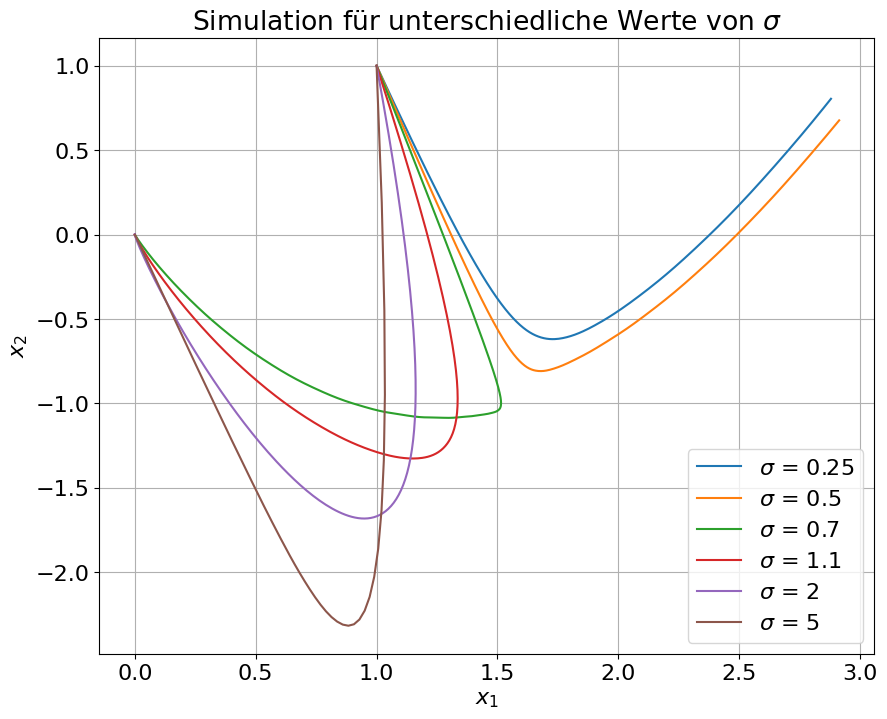

In [7]:
sigma_values = [0.25, 0.5, 0.7, 1.1, 2, 5]
a = 1.0
k_1 = 2
plt.figure(figsize=(10,8))
for sigma in sigma_values:
    k_2 = calc_k2(k_1, sigma)
    sol = sci.solve_ivp(lambda t, x: dgl_sys(x, a, k_1, k_2), [0, t_sim], x_0, t_eval=t, events=[stop_event])
    plt.plot(sol.y[0, :], sol.y[1,:], label='$\sigma$ = {}'.format(sigma))
plt.grid()
plt.title('Simulation für unterschiedliche Werte von $\sigma$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()